# Introduction to scRNA-seq integration

This tutorial is largely copied from the Seurat ["Introduction to scRNA-seq integration" vignette](https://satijalab.org/seurat/articles/integration_introduction.html)

The joint analysis of two or more single-cell datasets poses unique challenges. In particular, identifying cell populations that are present across multiple datasets can be problematic under standard workflows. Seurat v4 includes a set of methods to match (or ‘align’) shared cell populations across datasets. These methods first identify cross-dataset pairs of cells that are in a matched biological state (‘anchors’), can be used both to correct for technical differences between datasets (i.e. batch effect correction), and to perform comparative scRNA-seq analysis of across experimental conditions.

The code below demonstrates methods for scRNA-seq integration as described in [Stuart*, Butler* et al, 2019](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8) to perform a comparative analysis of human immune cells (PBMC) in either a [resting or interferon-stimulated state](https://www.nature.com/articles/nbt.4042).

## Integration goals

The following tutorial is designed to give you an overview of the kinds of comparative analyses on complex cell types that are possible using the Seurat integration procedure. Here, we address a few key goals:

- Create an ‘integrated’ data assay for downstream analysis
- Identify cell types that are present in both datasets
- Obtain cell type markers that are conserved in both control and stimulated cells
- Compare the datasets to find cell-type specific responses to stimulation


## Docker note

I found that the following code would not run properly unless I increased the resources available to the docker.  I have them set at:
- CPUs: 8
- Memory: 8.00 GB
- Swap: 2 GB
- Disk image size: 59.6 GB

## Setup the Seurat objects

We will use the same ifnb dataset we used in the merge tutorial distributed through the SeuratData package.  If you have not yet installed that package, see the merge_tutorial.ipynb.

In [1]:
options(warn=-1)
library(Seurat)
library(SeuratData)
library(patchwork)
library(ggplot2)
library(dplyr)

Attaching SeuratObject

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Installed datasets ───────────────────────────────────── SeuratData v0.2.1 ──

✔ ifnb 3.1.0                            


────────────────────────────────────── Key ─────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# install dataset
options(warn=-1)
InstallData("ifnb")

In [3]:
# load dataset
options(warn=-1)
LoadData("ifnb")

An object of class Seurat 
14053 features across 13999 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)

In [4]:
# split the dataset into a list of two seurat objects (stim and CTRL)
seurat.list <- SplitObject(ifnb, split.by = "stim")
seurat.list

$CTRL
An object of class Seurat 
14053 features across 6548 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)

$STIM
An object of class Seurat 
14053 features across 7451 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)


### Perform integration

First we normalize and find variable features for each separate SeuratObject.

If you have your own data that you've preprocessed as individual samples, they will already be normalized and have variable features.  If you had SeuratObjects called sample1 and sample2, you can put them into a list with:

`seurat.list <- list(sample1, sample2)`

In [5]:
seurat.list <- lapply(X = seurat.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

In [6]:
# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = seurat.list)

We then identify anchors using the `FindIntegrationAnchors()` function, which takes a list of Seurat objects as input, and use these anchors to integrate the two datasets together with `IntegrateData()`.

In [7]:
## with the given data this step takes about 4 minutes.
seurat.anchors <- FindIntegrationAnchors(object.list = seurat.list, 
                                         anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16393 anchors

Filtering anchors

	Retained 6756 anchors



In [8]:
# this command creates an 'integrated' data assay
seurat.int <- IntegrateData(anchorset = seurat.anchors)

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



### Perform an integrated analysis

Now we can run a single integrated analysis on all cells!

In [9]:
# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(seurat.int) <- "integrated"

In [10]:
# Run the standard workflow for visualization and clustering
seurat.int <- ScaleData(seurat.int, verbose = FALSE)
seurat.int <- RunPCA(seurat.int, npcs = 30, verbose = FALSE)
seurat.int <- RunUMAP(seurat.int, reduction = "pca", dims = 1:30, verbose = FALSE)
seurat.int <- FindNeighbors(seurat.int, reduction = "pca", dims = 1:30, verbose = FALSE)
seurat.int <- FindClusters(seurat.int, resolution = 0.5, verbose = FALSE)

### Visualization

If you are analyzing your own samples, instead of "stim" you will likely want to use "orig.ident" which should hold a unique identity for each of your samples (You may remember that this comes from the project argument in `CreateSeuratObject()`).

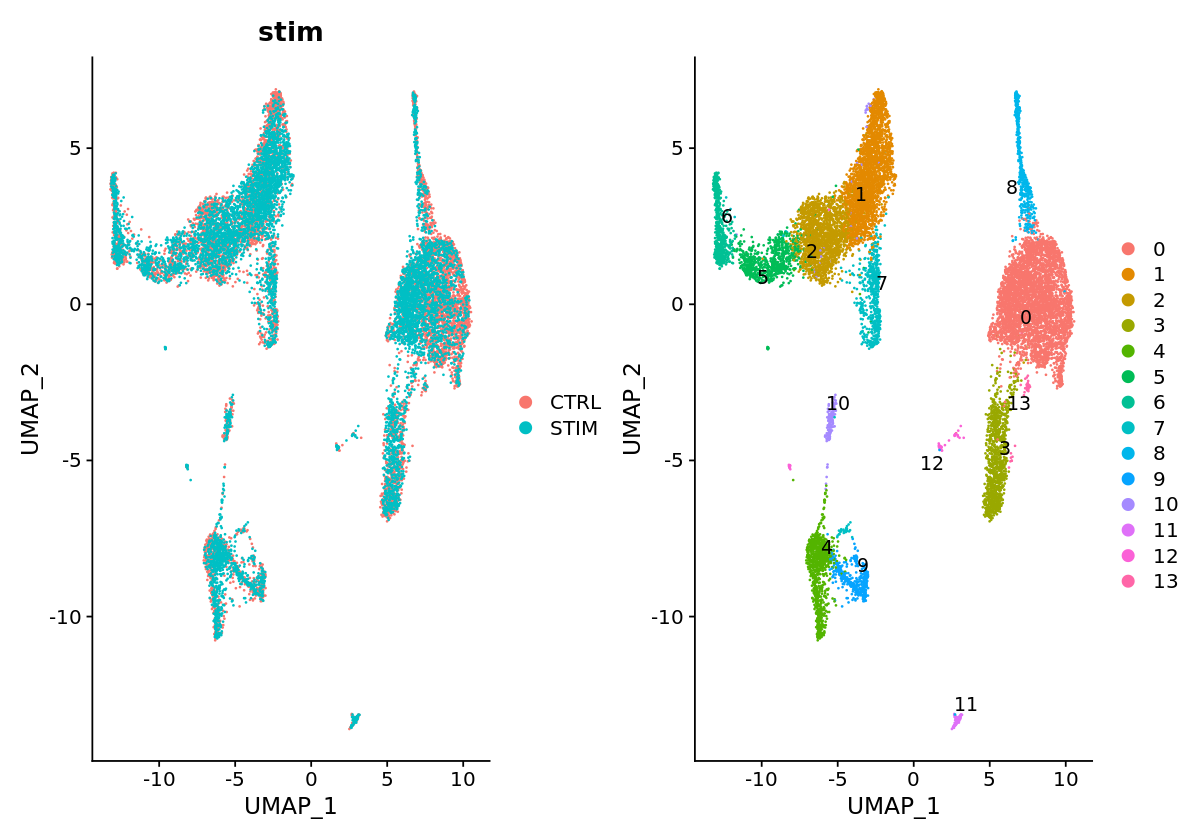

In [11]:
options(repr.plot.width=10, repr.plot.height=7)
p1 <- DimPlot(seurat.int, reduction = "umap", group.by = "stim")
p2 <- DimPlot(seurat.int, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

To visualize the two conditions side-by-side, we can use the split.by argument to show each condition colored by cluster.

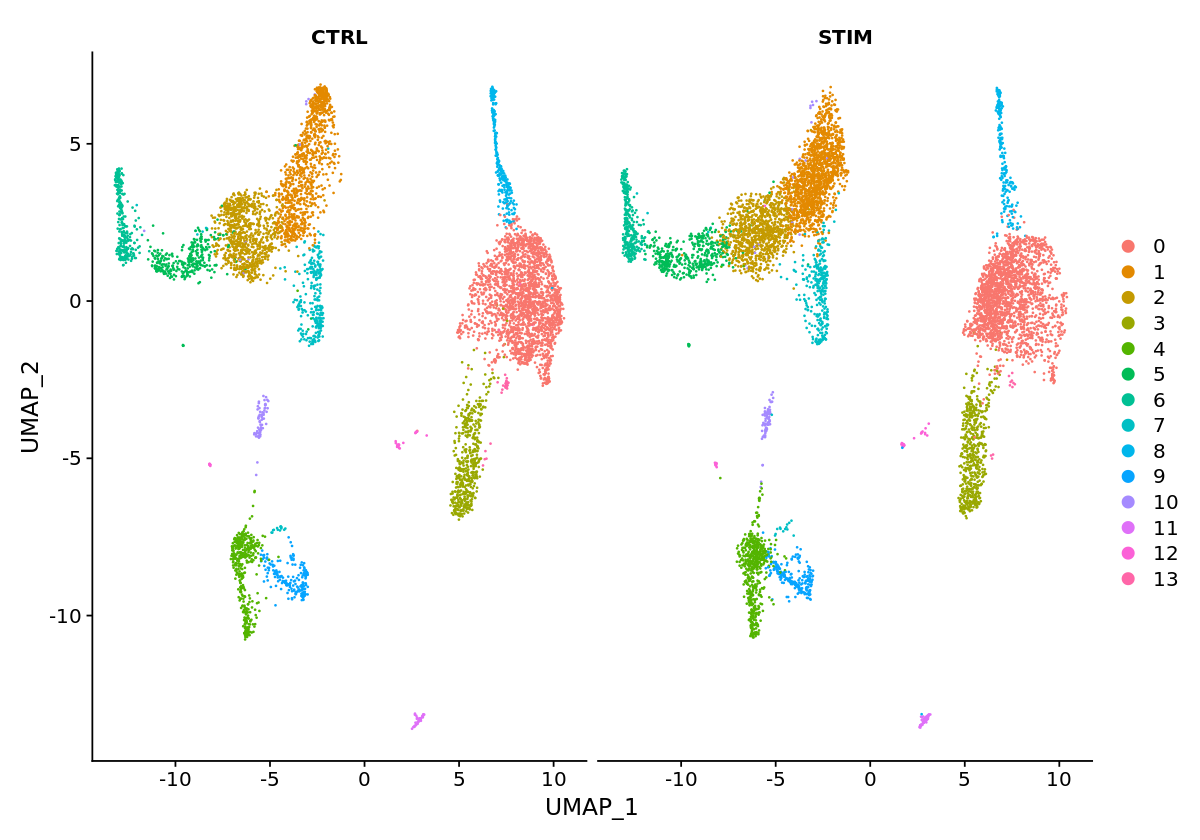

In [12]:
DimPlot(seurat.int, reduction = "umap", split.by = "stim")

### Identify conserved cell type markers

To identify canonical cell type marker genes that are conserved across conditions, Seurat had the `FindConservedMarkers()` function. This function performs differential gene expression testing for each dataset/group and combines the p-values using meta-analysis methods from the MetaDE R package. For example, we can calculated the genes that are conserved markers irrespective of stimulation condition in cluster 6 (NK cells).

**NOTE:** 
- When determining cell visualization and clustering (`RunPCA()`, `RunUMAP()`,`RunTSNE()`, `FindNeighbors()`, `FindClusters()`) use the assay "integrated"
- When examining or comparing gene expression use the original, normalized data which is in the assay "RNA" or if you have done `SCTransform()` normalization it is in the assay "SCT"

In [13]:
# For performing differential expression after integration, we switch back to the original
# data
DefaultAssay(seurat.int) <- "RNA"
nk.markers <- FindConservedMarkers(seurat.int, ident.1 = 6, grouping.var = "stim", verbose = FALSE)
head(nk.markers)

,CTRL_p_val,CTRL_avg_log2FC,CTRL_pct.1,CTRL_pct.2,CTRL_p_val_adj,STIM_p_val,STIM_avg_log2FC,STIM_pct.1,STIM_pct.2,STIM_p_val_adj,max_pval,minimump_p_val
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GNLY,0,6.006422,0.944,0.045,0,0.000000e+00,5.863771,0.956,0.060,0.000000e+00,0.000000e+00,0
FGFBP2,0,3.223246,0.503,0.020,0,2.789932e-160,2.196674,0.259,0.016,3.920691e-156,2.789932e-160,0
CLIC3,0,3.466418,0.599,0.024,0,0.000000e+00,3.545647,0.625,0.031,0.000000e+00,0.000000e+00,0
PRF1,0,2.654683,0.424,0.017,0,0.000000e+00,4.100747,0.863,0.057,0.000000e+00,0.000000e+00,0
CTSW,0,2.991829,0.533,0.029,0,0.000000e+00,3.135466,0.594,0.035,0.000000e+00,0.000000e+00,0
KLRD1,0,2.781453,0.497,0.019,0,0.000000e+00,2.875972,0.556,0.027,0.000000e+00,0.000000e+00,0


There is no `FindConservedMarkers()` equivalent to `FindAllMarkers()`.  So if you'd like to find the conserved markers for all clusters, you can use something like the following for loop.  This is commented out because it can take a long time to run.

In [14]:
#DefaultAssay(seurat.int) <- "RNA"
#All.cons.markers <- list()
#for(cluster in levels(seurat.int)){
#  All.cons.markers[[cluster]] <- FindConservedMarkers(seurat.int, ident.1 = cluster, 
#                                                      grouping.var = "stim", verbose = FALSE)
#}

We can explore these known PBMC marker genes for each cluster and use them to annotate our clusters as specific cell types.

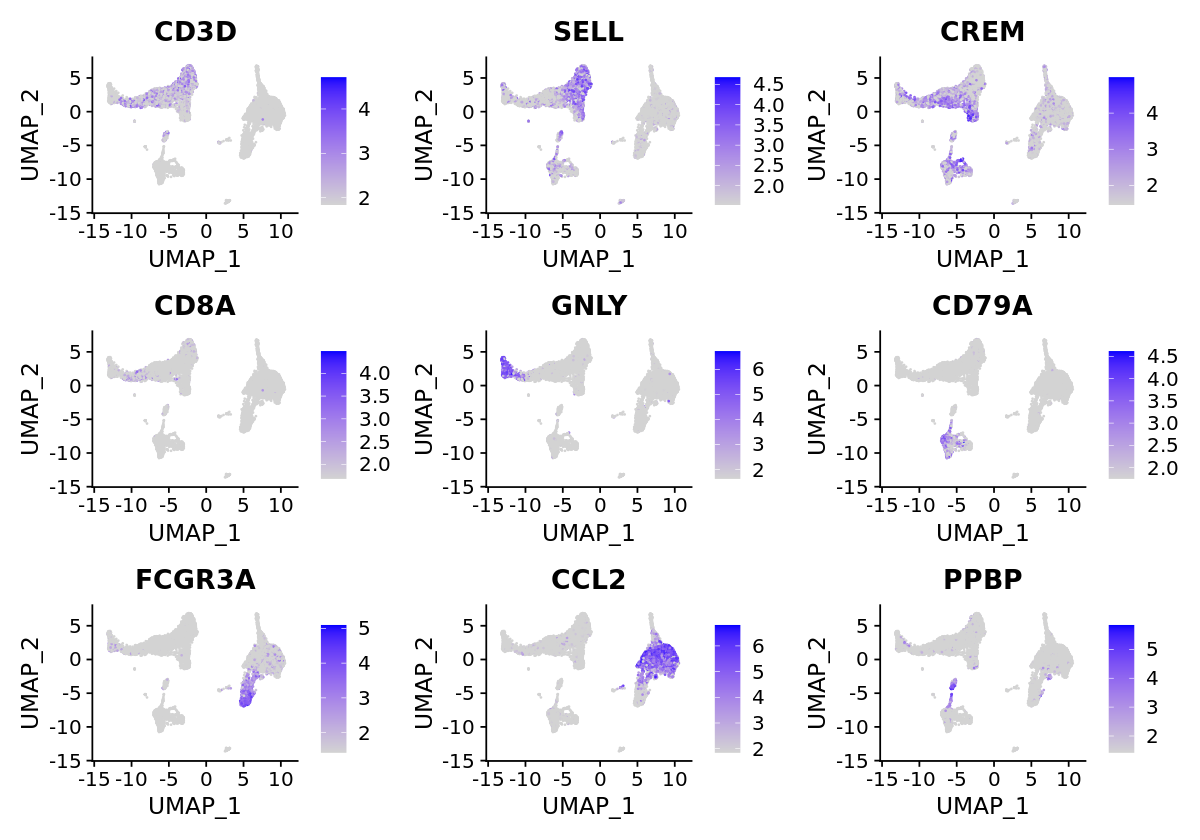

In [15]:
FeaturePlot(seurat.int, features = c("CD3D", "SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A",
    "CCL2", "PPBP"), min.cutoff = "q9")

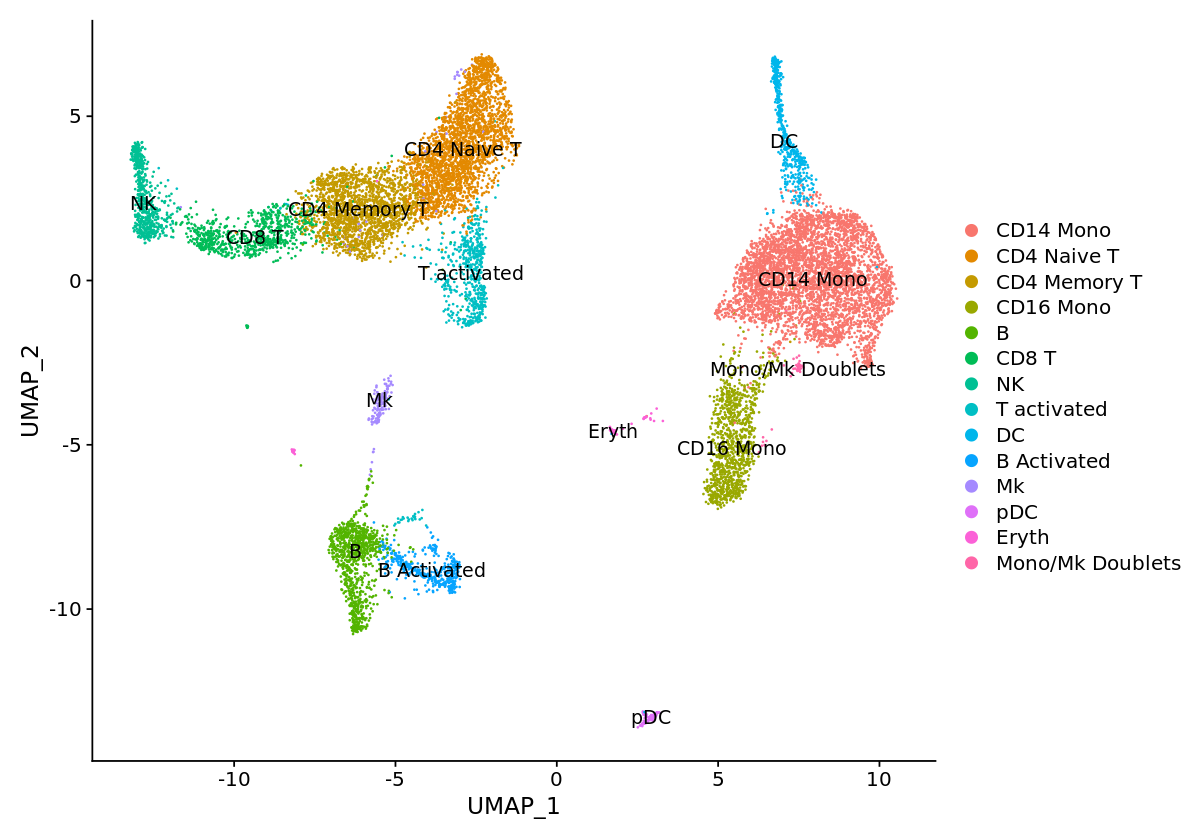

In [16]:
seurat.int <- RenameIdents(seurat.int, `0` = "CD14 Mono", `1` = "CD4 Naive T", `2` = "CD4 Memory T",
    `3` = "CD16 Mono", `4` = "B", `5` = "CD8 T", `6` = "NK", `7` = "T activated", `8` = "DC", `9` = "B Activated",
    `10` = "Mk", `11` = "pDC", `12` = "Eryth", `13` = "Mono/Mk Doublets", `14` = "HSPC")
seurat.int$Clusters <- Idents(seurat.int)
DimPlot(seurat.int, label = TRUE)

The `DotPlot()` function with the split.by parameter can be useful for viewing conserved cell type markers across conditions, showing both the expression level and the percentage of cells in a cluster expressing any given gene. Here we plot 2-3 strong marker genes for each of our 14 clusters.

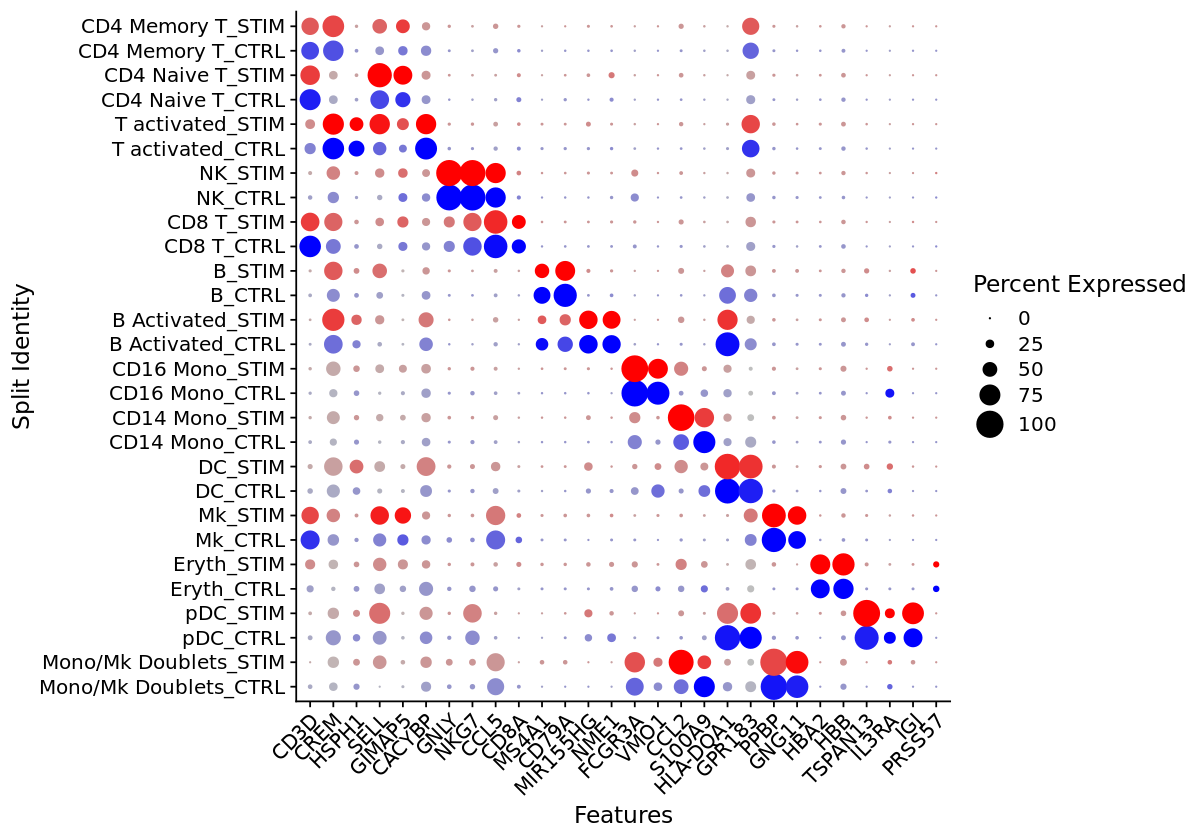

In [17]:
Idents(seurat.int) <- factor(Idents(seurat.int), levels = c("HSPC", "Mono/Mk Doublets",
    "pDC", "Eryth", "Mk", "DC", "CD14 Mono", "CD16 Mono", "B Activated", "B", "CD8 T", "NK", "T activated",
    "CD4 Naive T", "CD4 Memory T"))
markers.to.plot <- c("CD3D", "CREM", "HSPH1", "SELL", "GIMAP5", "CACYBP", "GNLY", "NKG7", "CCL5",
    "CD8A", "MS4A1", "CD79A", "MIR155HG", "NME1", "FCGR3A", "VMO1", "CCL2", "S100A9", "HLA-DQA1",
    "GPR183", "PPBP", "GNG11", "HBA2", "HBB", "TSPAN13", "IL3RA", "IGJ", "PRSS57")
DotPlot(seurat.int, features = markers.to.plot, cols = c("blue", "red"), dot.scale = 7, split.by = "stim") +
    RotatedAxis()

### Identify differential expressed genes across conditions

Now that we’ve aligned the stimulated and control cells, we can start to do comparative analyses and look at the differences induced by stimulation. One way to look broadly at these changes is to plot the average expression of both the stimulated and control cells and look for genes that are visual outliers on a scatter plot. Here, we take the average expression of both the stimulated and control naive T cells and CD14 monocyte populations and generate the scatter plots, highlighting genes that exhibit dramatic responses to interferon stimulation.

When using repel, set xnudge and ynudge to 0 for optimal results

When using repel, set xnudge and ynudge to 0 for optimal results



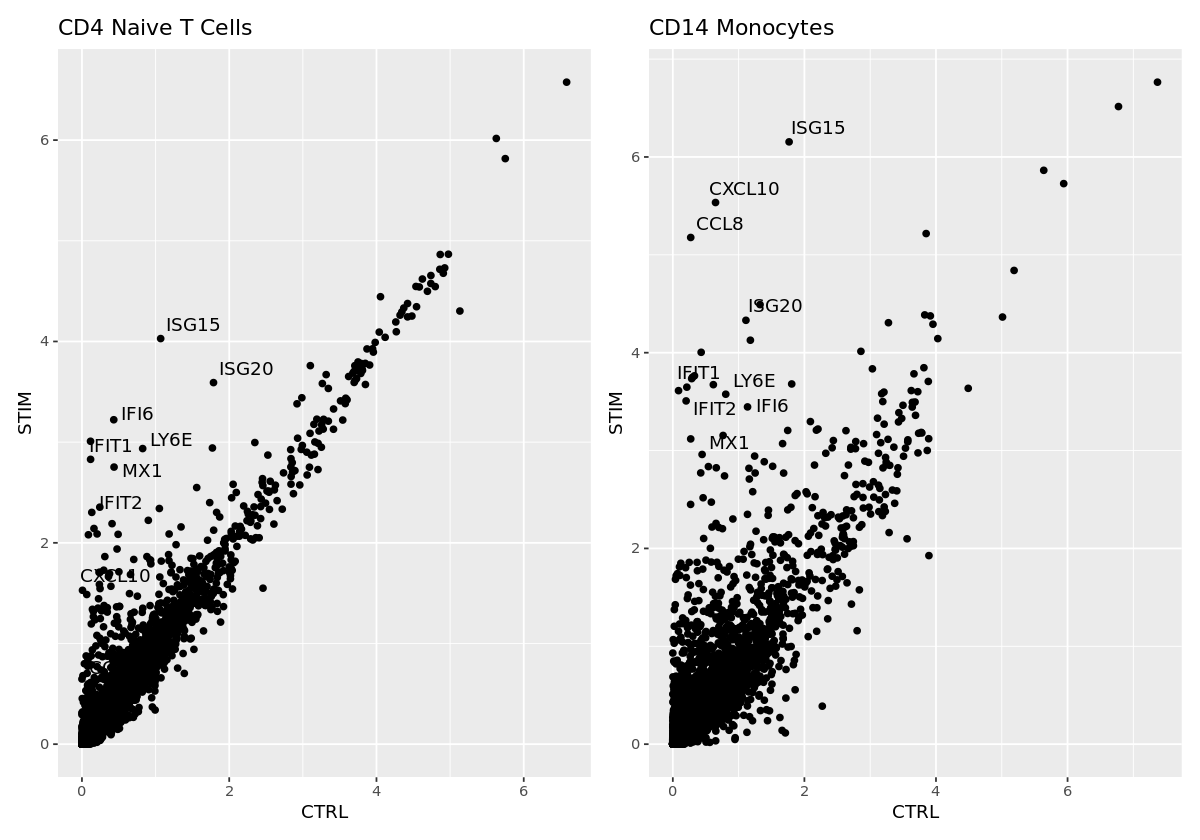

In [18]:
t.cells <- subset(seurat.int, idents = "CD4 Naive T")
Idents(t.cells) <- "stim"
avg.t.cells <- as.data.frame(log1p(AverageExpression(t.cells, verbose = FALSE)$RNA))
avg.t.cells$gene <- rownames(avg.t.cells)

cd14.mono <- subset(seurat.int, idents = "CD14 Mono")
Idents(cd14.mono) <- "stim"
avg.cd14.mono <- as.data.frame(log1p(AverageExpression(cd14.mono, verbose = FALSE)$RNA))
avg.cd14.mono$gene <- rownames(avg.cd14.mono)

genes.to.label = c("ISG15", "LY6E", "IFI6", "ISG20", "MX1", "IFIT2", "IFIT1", "CXCL10", "CCL8")
p1 <- ggplot(avg.t.cells, aes(CTRL, STIM)) + geom_point() + ggtitle("CD4 Naive T Cells")
p1 <- LabelPoints(plot = p1, points = genes.to.label, repel = TRUE)
p2 <- ggplot(avg.cd14.mono, aes(CTRL, STIM)) + geom_point() + ggtitle("CD14 Monocytes")
p2 <- LabelPoints(plot = p2, points = genes.to.label, repel = TRUE)
p1 + p2

To help understand the code above, it's useful to look at what avg.t.cells looks like.

In [19]:
head(avg.t.cells)

,CTRL,STIM,gene
,<dbl>,<dbl>,<chr>
AL627309.1,0.000000000,0.000000000,AL627309.1
RP11-206L10.2,0.007066129,0.000000000,RP11-206L10.2
LINC00115,0.015736246,0.000000000,LINC00115
NOC2L,0.559315804,0.626681300,NOC2L
KLHL17,0.007630363,0.000000000,KLHL17
PLEKHN1,0.010527743,0.004971612,PLEKHN1


In your experimental scRNA-seq datasets, you might not know off hand which genes to label.  You can use `lm()` which is a base R function to fit linear models along with `predict()` and `residuals()` to find the linear regression through the data and calculate the distance from this line for each gene.  In the example below, we've selected the genes with a residual absolute value > 1.5 which gives a reasonable number of genes to label.

When using repel, set xnudge and ynudge to 0 for optimal results

`geom_smooth()` using formula 'y ~ x'



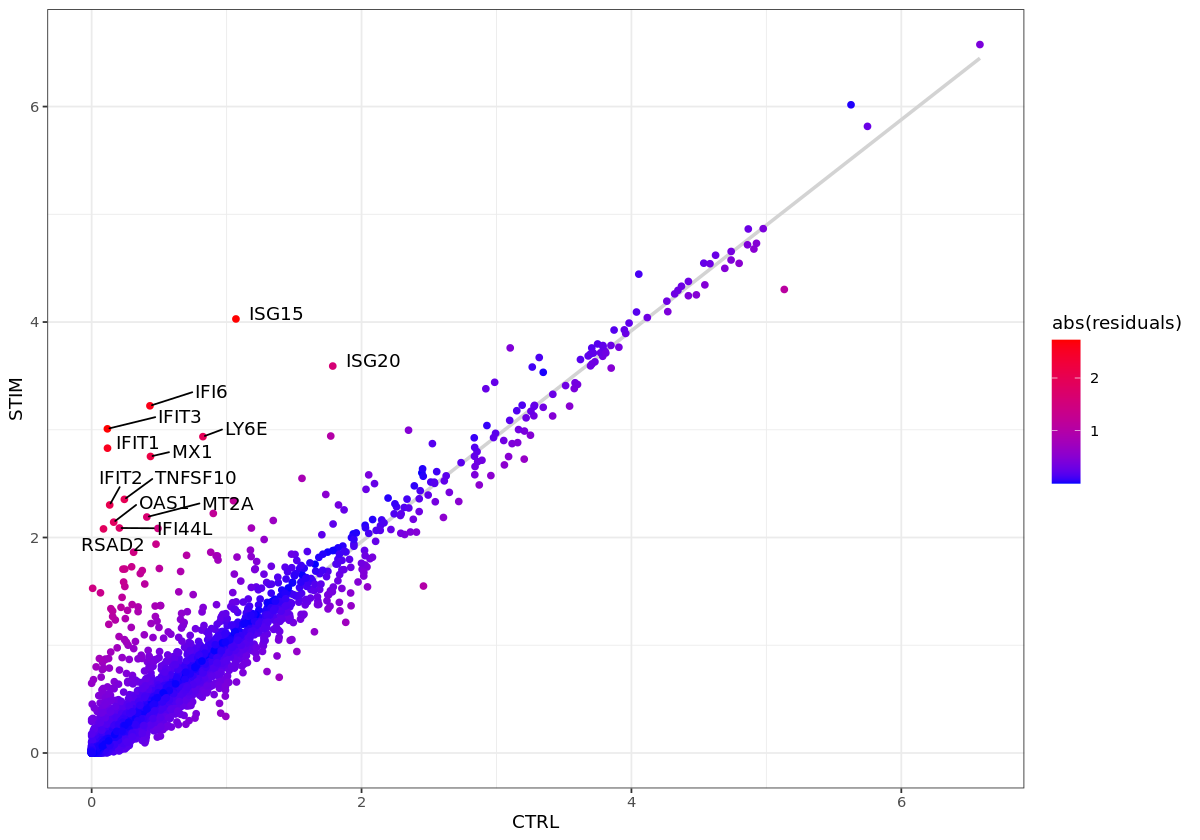

In [20]:
fit.tcells <- lm(CTRL ~ STIM, data = avg.t.cells) # fit the model
avg.t.cells$predicted <- predict(fit.tcells)                                # Save the predicted values
avg.t.cells$residuals <- residuals(fit.tcells)                              # Save the residual values
genes.to.label <- rownames(avg.t.cells[abs(avg.t.cells$residuals) > 1.5,])  # find genes with residual abs value > 1.5
p <- ggplot(avg.t.cells, aes(CTRL, STIM)) +
  geom_smooth(method = "lm", se = FALSE, color = "lightgrey") +   # regression line  
  geom_point(aes(color = abs(residuals))) +                       # plot the points
  scale_color_continuous(low = "blue", high = "red") +            # colour of the points mapped to residual size - green smaller, red larger
  theme_bw()                                                      # removes the grey background
p <- LabelPoints(plot = p, points = genes.to.label , repel = TRUE)   # adds labels to plot
p

As you can see, many of the same genes are upregulated in both of these cell types and likely represent a conserved interferon response pathway.

Because we are confident in having identified common cell types across condition, we can ask what genes change in different conditions for cells of the same type. First, we create a column in the meta.data slot to hold both the cell type and stimulation information and switch the current ident to that column. 

In [22]:
seurat.int$celltype.stim <- paste(seurat.int$Clusters, seurat.int$stim, sep = "_")

Then we use `FindMarkers()` to find the genes that are different between stimulated and control B cells. Notice that many of the top genes that show up here are the same as the ones we plotted earlier as core interferon response genes. Additionally, genes like CXCL10 which we saw were specific to monocyte and B cell interferon response show up as highly significant in this list as well.

In [23]:
Idents(seurat.int) <- "celltype.stim"
b.interferon.response <- FindMarkers(seurat.int, ident.1 = "B_STIM", ident.2 = "B_CTRL", verbose = FALSE)
head(b.interferon.response, n = 15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ISG15,4.062910e-156,4.5954499,0.998,0.239,5.709608e-152
IFIT3,1.588473e-151,4.5037054,0.964,0.052,2.232282e-147
IFI6,1.712574e-150,4.2368112,0.968,0.080,2.406680e-146
ISG20,5.714513e-147,2.9377442,1.000,0.672,8.030605e-143
IFIT1,4.309604e-138,4.1300511,0.912,0.032,6.056287e-134
MX1,2.314844e-121,3.2905213,0.905,0.114,3.253051e-117
LY6E,4.438547e-118,3.1263990,0.895,0.152,6.237490e-114
TNFSF10,5.803777e-111,3.7821649,0.793,0.025,8.156048e-107
IFIT2,2.623571e-106,3.6576581,0.784,0.035,3.686904e-102


Another useful way to visualize these changes in gene expression is with the split.by option to the `FeaturePlot()` or `VlnPlot()` function. This will display FeaturePlots of the list of given genes, split by a grouping variable (stimulation condition here). Genes such as CD3D and GNLY are canonical cell type markers (for T cells and NK/CD8 T cells) that are virtually unaffected by interferon stimulation and display similar gene expression patterns in the control and stimulated group. IFI6 and ISG15, on the other hand, are core interferon response genes and are upregulated accordingly in all cell types. Finally, CD14 and CXCL10 are genes that show a cell type specific interferon response. CD14 expression decreases after stimulation in CD14 monocytes, which could lead to misclassification in a supervised analysis framework, underscoring the value of integrated analysis. CXCL10 shows a distinct upregulation in monocytes and B cells after interferon stimulation but not in other cell types.

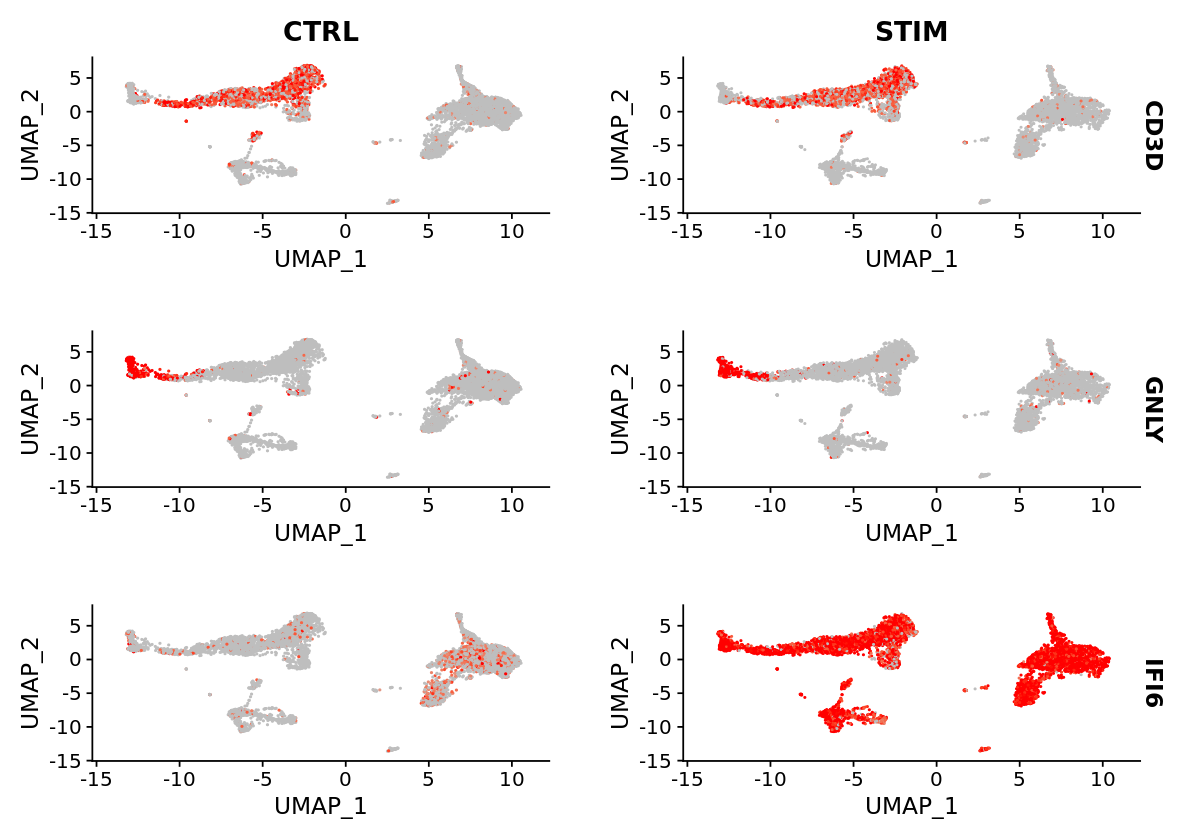

In [24]:
FeaturePlot(seurat.int, features = c("CD3D", "GNLY", "IFI6"), split.by = "stim", max.cutoff = 3,
    cols = c("grey", "red"))

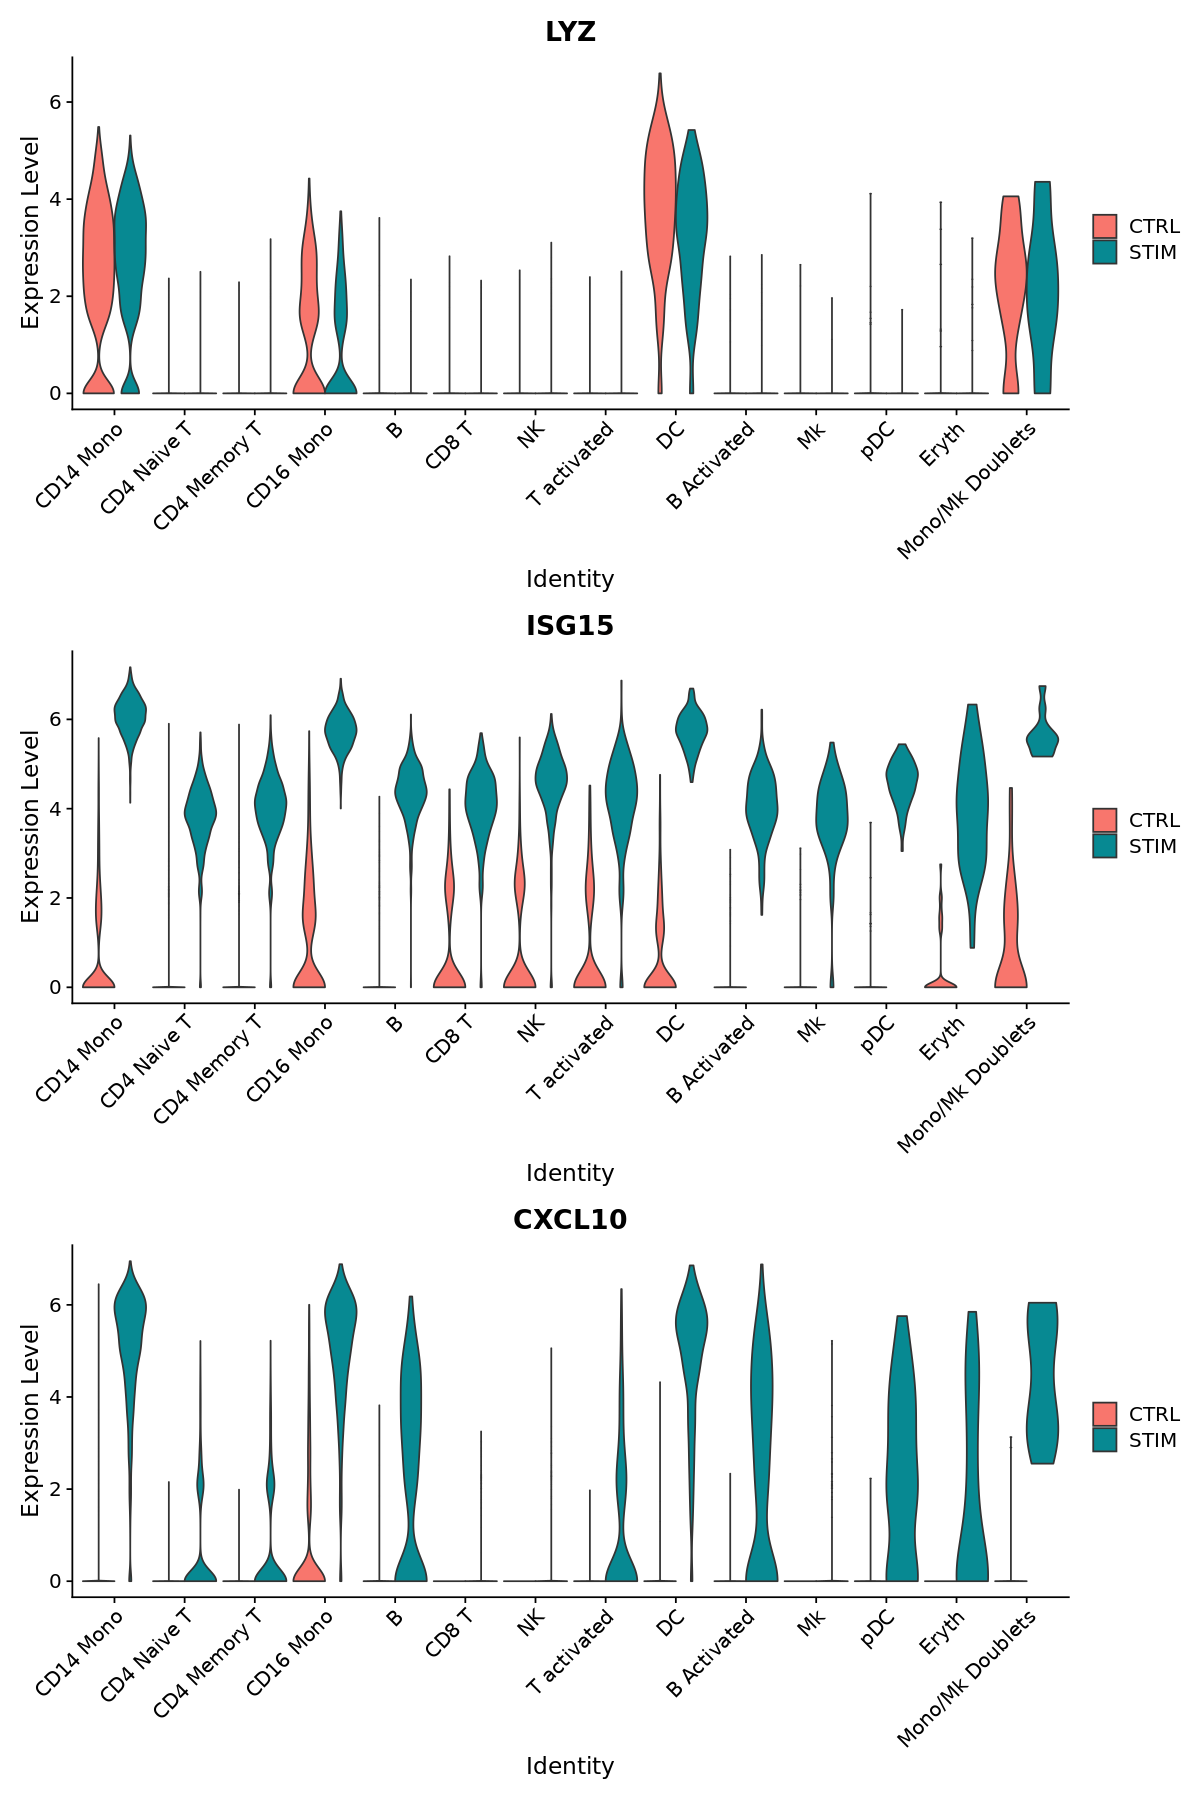

In [27]:
options(repr.plot.width=10, repr.plot.height=15)
plots <- VlnPlot(seurat.int, features = c("LYZ", "ISG15", "CXCL10"), split.by = "stim", group.by = "Clusters",
    pt.size = 0, combine = FALSE)
wrap_plots(plots = plots, ncol = 1)